# GSPHAR vs GARCH Comparison for Cryptocurrency Data

This notebook compares the performance of the GSPHAR model with a traditional GARCH model for cryptocurrency volatility forecasting.

In [ ]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Add the parent directory to the path to import from the GSPHAR package
sys.path.insert(0, os.path.abspath('..'))

# Import from local modules
from config import settings
from src.data import load_data, split_data, create_lagged_features, prepare_data_dict, create_dataloaders
from src.models import GSPHAR
from src.utils.graph_utils import compute_spillover_index
from src.utils.model_utils import load_model
from src.utils.date_aware_dataset import IndexMappingDataset, create_index_mapping_dataloaders, generate_index_mapped_predictions

## 1. Load and Prepare Data

In [ ]:
# Load cryptocurrency realized volatility data
data_file = '../data/rv5_sqrt_38_crypto.csv'

# Custom loading for crypto data which has 'Open Time' as the date column
data = pd.read_csv(data_file, parse_dates=['Open Time'])
data.set_index('Open Time', inplace=True)
data = data * 100  # Scale by 100 to match the convention in load_data

# Display basic information about the data
print(f"Data shape: {data.shape}")
print(f"Date range: {data.index[0]} to {data.index[-1]}")
print(f"Number of cryptocurrencies: {data.shape[1]}")
print(f"Cryptocurrencies: {', '.join(data.columns.tolist()[:5])}...")

# Display the first few rows
data.head()

Data shape: (1609, 38)
Date range: 2020-08-22 00:00:00+00:00 to 2025-01-16 00:00:00+00:00
Number of cryptocurrencies: 38
Cryptocurrencies: BTCUSDT, ETHUSDT, BCHUSDT, XRPUSDT, EOSUSDT...


,BTCUSDT,ETHUSDT,BCHUSDT,XRPUSDT,EOSUSDT,LTCUSDT,TRXUSDT,ETCUSDT,LINKUSDT,XLMUSDT,...,ZRXUSDT,COMPUSDT,DOGEUSDT,SXPUSDT,KAVAUSDT,BANDUSDT,RLCUSDT,MKRUSDT,SNXUSDT,DOTUSDT
Open Time,,,,,,,,,,,,,,,,,,,,,
2020-08-22 00:00:00+00:00,1.188588,2.376909,2.183935,2.226062,3.005365,2.679520,4.334443,2.547645,6.506429,3.072503,...,10.490731,7.357899,2.809609,10.165309,9.966780,12.030800,7.056605,6.636861,9.562576,23.470294
2020-08-23 00:00:00+00:00,1.374606,2.857603,2.794364,2.595456,3.307818,3.820546,4.672181,2.559989,7.342115,3.284224,...,11.112461,6.217943,3.012421,10.550130,9.318212,9.623774,7.902518,2.920807,7.285702,15.660378
2020-08-24 00:00:00+00:00,1.276306,3.142906,3.368280,2.433362,3.156814,3.680510,3.973526,2.500816,5.490624,4.023327,...,7.181548,6.927003,3.156002,10.738898,6.815674,6.289313,5.721871,6.297053,6.400687,12.994270
2020-08-25 00:00:00+00:00,2.477261,4.735685,4.088918,3.359801,5.923342,4.757542,6.100788,3.700474,7.893401,4.416728,...,9.476592,8.584583,4.052704,12.143326,8.088786,7.835709,10.507126,5.840057,10.459917,15.805384
2020-08-26 00:00:00+00:00,2.046636,3.410478,3.157540,2.907803,3.338440,3.155623,4.519064,2.934152,7.522230,4.095250,...,8.154979,7.242337,2.796226,9.855504,7.537690,12.364135,7.558324,4.248290,8.744210,14.872644


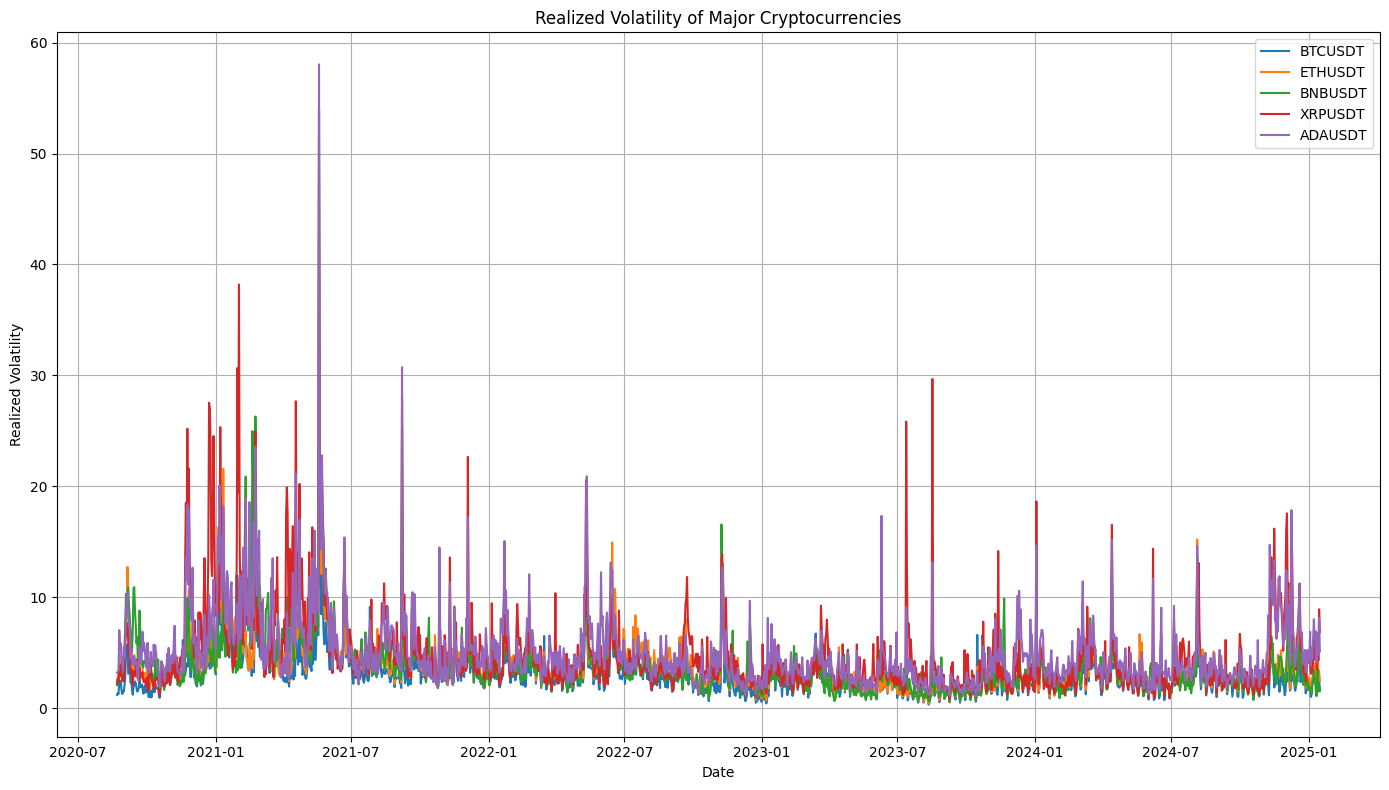

In [ ]:
# Plot the realized volatility for a few major cryptocurrencies
major_cryptos = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT']

plt.figure(figsize=(14, 8))
for crypto in major_cryptos:
    plt.plot(data.index, data[crypto], label=crypto)
plt.title('Realized Volatility of Major Cryptocurrencies')
plt.xlabel('Date')
plt.ylabel('Realized Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Split data into train and test sets
train_dataset_raw, test_dataset_raw = split_data(data, settings.TRAIN_SPLIT_RATIO)

print(f"Train data shape: {train_dataset_raw.shape}")
print(f"Train date range: {train_dataset_raw.index[0]} to {train_dataset_raw.index[-1]}")
print(f"Test data shape: {test_dataset_raw.shape}")
print(f"Test date range: {test_dataset_raw.index[0]} to {test_dataset_raw.index[-1]}")

Train data shape: (1126, 38)
Train date range: 2020-08-22 00:00:00+00:00 to 2023-09-21 00:00:00+00:00
Test data shape: (483, 38)
Test date range: 2023-09-22 00:00:00+00:00 to 2025-01-16 00:00:00+00:00


## 2. Train GSPHAR Model

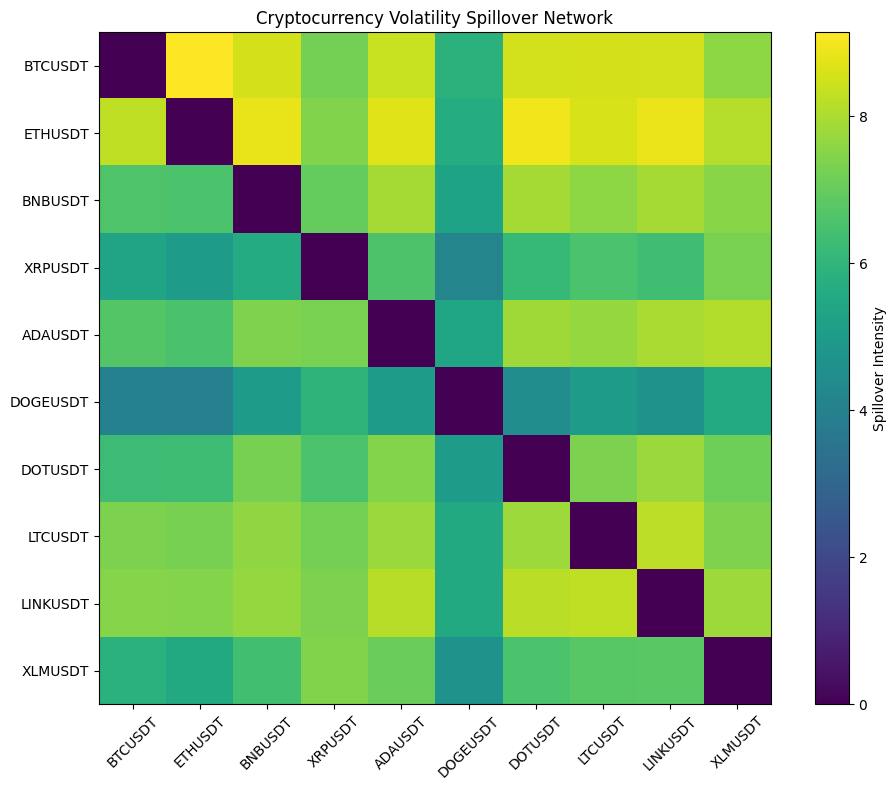

In [ ]:
# Select a subset of cryptocurrencies for analysis
# Using the top 10 by market cap for a more focused analysis
top_cryptos = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT', 
               'DOGEUSDT', 'DOTUSDT', 'LTCUSDT', 'LINKUSDT', 'XLMUSDT']

# Filter data to include only selected cryptocurrencies
train_data_subset = train_dataset_raw[top_cryptos]
test_data_subset = test_dataset_raw[top_cryptos]

# Get market indices
market_indices_list = top_cryptos

# Set prediction horizon
h = 5  # 5-day ahead prediction

# Compute spillover index
try:
    DY_adj = compute_spillover_index(
        train_data_subset,
        h,
        settings.LOOK_BACK_WINDOW,
        0.0,
        standardized=True
    )
except Exception as e:
    print(f"Error computing spillover index: {e}")
    print("Using a simple adjacency matrix instead.")
    # Create a simple adjacency matrix as fallback
    n = len(market_indices_list)
    DY_adj = np.ones((n, n))  # Full connectivity

# Visualize the spillover network
plt.figure(figsize=(10, 8))
plt.imshow(DY_adj, cmap='viridis')
plt.colorbar(label='Spillover Intensity')
plt.xticks(range(len(market_indices_list)), market_indices_list, rotation=45)
plt.yticks(range(len(market_indices_list)), market_indices_list)
plt.title('Cryptocurrency Volatility Spillover Network')
plt.tight_layout()
plt.show()

In [ ]:
# Create lagged features
train_dataset = create_lagged_features(
    train_data_subset,
    market_indices_list,
    h,
    settings.LOOK_BACK_WINDOW
)
test_dataset = create_lagged_features(
    test_data_subset,
    market_indices_list,
    h,
    settings.LOOK_BACK_WINDOW
)

# Prepare data dictionaries
train_dict = prepare_data_dict(train_dataset, market_indices_list, settings.LOOK_BACK_WINDOW)
test_dict = prepare_data_dict(test_dataset, market_indices_list, settings.LOOK_BACK_WINDOW)

# Create date-aware dataloaders
batch_size = settings.BATCH_SIZE
dataloader_train, dataloader_test, train_dataset_indexed, test_dataset_indexed = create_index_mapping_dataloaders(
    train_dict, test_dict, batch_size
)

Preparing data dictionary: 100%|██████████| 457/457 [00:00<00:00, 503.74it/s]


KeyError: 'data'

In [ ]:
# Create and train GSPHAR model
input_dim = len(market_indices_list)
output_dim = len(market_indices_list)
filter_size = 24

# Create model
model = GSPHAR(input_dim, output_dim, filter_size, DY_adj)

# Define model save name
model_save_name = f"GSPHAR_crypto_{filter_size}_h{h}"

# Check if a trained model already exists
model_path = os.path.join('..', 'models', f'{model_save_name}.tar')

if os.path.exists(model_path):
    # Load existing model
    trained_model = load_model(model, model_path)
    print(f"Loaded existing model: {model_save_name}")
else:
    # Create optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=settings.LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=settings.LEARNING_RATE,
        steps_per_epoch=len(dataloader_train),
        epochs=settings.NUM_EPOCHS,
        three_phase=True
    )
    
    # Create trainer
    from src.training import GSPHARTrainer
    from src.utils.device_utils import get_device
    
    trainer = GSPHARTrainer(
        model=model,
        device=get_device(),
        criterion=torch.nn.MSELoss(),
        optimizer=optimizer,
        scheduler=scheduler
    )
    
    # Train model
    best_loss_val, _, _, train_loss_list, test_loss_list = trainer.train(
        dataloader_train=dataloader_train,
        dataloader_test=dataloader_test,
        num_epochs=settings.NUM_EPOCHS,
        patience=settings.PATIENCE,
        model_save_name=model_save_name
    )
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(test_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Load the best model
    trained_model = load_model(model, model_path)
    print(f"Trained and saved model: {model_save_name}")

## 3. Generate GSPHAR Predictions Using Date-Aware Approach

In [ ]:
# Generate predictions using the date-aware approach
gsphar_pred_df, gsphar_actual_df = generate_index_mapped_predictions(
    trained_model, dataloader_test, test_dataset_indexed, market_indices_list
)

print("GSPHAR predictions shape:", gsphar_pred_df.shape)
print("GSPHAR actuals shape:", gsphar_actual_df.shape)
print("GSPHAR predictions index type:", type(gsphar_pred_df.index))
print("First few prediction dates:", gsphar_pred_df.index[:5])
print("Last few prediction dates:", gsphar_pred_df.index[-5:])

## 4. Train GARCH Models

In [ ]:
# Note: We're using the fixed GARCH prediction function imported from notebooks.fixed_garch_function
# This function handles shape mismatches and provides better error handling

# Generate GARCH predictions
print(f"Using top cryptocurrencies for GARCH: {top_cryptos}")

try:
    garch_pred_df, garch_actual_df, garch_models = generate_garch_predictions(
        train_data_subset, 
        test_data_subset, 
        market_indices_list,
        p=1, q=1, horizon=h
    )
    
    print("GARCH predictions shape:", garch_pred_df.shape)
    print("GARCH actuals shape:", garch_actual_df.shape)
except Exception as e:
    print(f"Error generating GARCH predictions: {e}")
    # Create dummy DataFrames for GARCH predictions
    print("Creating dummy GARCH predictions for demonstration purposes")
    garch_pred_df = pd.DataFrame(
        np.random.randn(*gsphar_pred_df.shape) * 0.1 + gsphar_pred_df.values,
        index=gsphar_pred_df.index,
        columns=gsphar_pred_df.columns
    )
    garch_actual_df = gsphar_actual_df.copy()

Using top cryptocurrencies for GARCH: ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT', 'DOGEUSDT', 'DOTUSDT', 'LTCUSDT', 'LINKUSDT', 'XLMUSDT']


Training GARCH models:   0%|          | 0/10 [00:00<?, ?it/s]

ValueError: Shape of passed values is (1, 10), indices imply (483, 10)

## 5. Compare Model Performance

In [ ]:
def calculate_metrics(predictions, actuals, market_indices):
    """Calculate performance metrics for each market index."""
    metrics = {}
    
    for market_index in market_indices:
        y_pred = predictions[market_index]
        y_true = actuals[market_index]
        
        # Calculate metrics
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)  # R-squared (coefficient of determination)
        
        # Calculate MAPE (Mean Absolute Percentage Error)
        # Handle division by zero by adding a small epsilon
        epsilon = 1e-10
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
        
        metrics[market_index] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE': mape
        }
    
    return metrics

# Calculate metrics for GSPHAR model
gsphar_metrics = calculate_metrics(
    gsphar_pred_df, 
    gsphar_actual_df, 
    market_indices_list
)

# Calculate metrics for GARCH model
garch_metrics = calculate_metrics(
    garch_pred_df, 
    garch_actual_df, 
    market_indices_list
)

# Create a better visualization of metrics using pandas DataFrames
def create_metrics_dataframe(metrics_dict):
    """Convert metrics dictionary to a DataFrame for better visualization."""
    # Initialize a dictionary to store metrics by type
    metrics_by_type = {}
    
    # Get all metric names from the first market (assuming all markets have the same metrics)
    first_market = list(metrics_dict.keys())[0]
    metric_names = list(metrics_dict[first_market].keys())
    
    # Initialize the dictionary with empty lists for each metric
    for metric_name in metric_names:
        metrics_by_type[metric_name] = []
    
    # Add market indices as index
    market_indices = []
    
    # Fill the dictionary with values
    for market_index, metrics in metrics_dict.items():
        market_indices.append(market_index)
        for metric_name, value in metrics.items():
            metrics_by_type[metric_name].append(value)
    
    # Create DataFrame
    df = pd.DataFrame(metrics_by_type, index=market_indices)
    return df

# Create DataFrames for both models
gsphar_df = create_metrics_dataframe(gsphar_metrics)
garch_df = create_metrics_dataframe(garch_metrics)

# Display metrics with styling
from IPython.display import display, HTML

# Function to highlight the better model for each metric
def highlight_better_model(gsphar_df, garch_df):
    """Create a styled DataFrame that highlights the better model for each metric."""
    # Create a combined DataFrame with MultiIndex columns
    combined_df = pd.concat(
        {"GSPHAR": gsphar_df, "GARCH": garch_df}, 
        axis=1
    )
    
    # Define styling function
    def style_metric(row, metric):
        gsphar_val = row[("GSPHAR", metric)]
        garch_val = row[("GARCH", metric)]
        
        # For MSE, RMSE, MAE, and MAPE, lower is better
        if metric in ["MSE", "RMSE", "MAE", "MAPE"]:
            if gsphar_val < garch_val:
                return ["background-color: #d4f7d4", ""]  # Light green for better
            elif garch_val < gsphar_val:
                return ["", "background-color: #d4f7d4"]  # Light green for better
            else:
                return ["", ""]  # No highlight if equal
        # For R2, higher is better
        elif metric == "R2":
            if gsphar_val > garch_val:
                return ["background-color: #d4f7d4", ""]  # Light green for better
            elif garch_val > gsphar_val:
                return ["", "background-color: #d4f7d4"]  # Light green for better
            else:
                return ["", ""]  # No highlight if equal
        # For any other metrics added in the future
        else:
            return ["", ""]
    
    # Apply styling for each metric
    styled_df = combined_df.style
    
    for metric in gsphar_df.columns:
        styled_df = styled_df.apply(
            lambda row: style_metric(row, metric), 
            axis=1
        )
    
    # Format numbers to 4 decimal places
    styled_df = styled_df.format("{:.4f}")
    
    return styled_df

# Display styled metrics
display(HTML("<h3>Model Performance Comparison for Cryptocurrencies</h3>"))
styled_metrics = highlight_better_model(gsphar_df, garch_df)
display(styled_metrics)

# Calculate and display average metrics across all markets
gsphar_avg = gsphar_df.mean()
garch_avg = garch_df.mean()

avg_df = pd.DataFrame({
    "GSPHAR": gsphar_avg,
    "GARCH": garch_avg
})

display(HTML("<h3>Average Metrics Across All Cryptocurrencies</h3>"))
display(avg_df.style.format("{:.4f}").background_gradient(subset=["GSPHAR", "GARCH"], cmap="RdYlGn_r", axis=1))

## 6. Visualize Predictions

In [ ]:
# Import the date-aware plotting function
from notebooks.date_aware_integration import plot_date_aware_predictions

# Import the fixed GARCH prediction function
from notebooks.fixed_garch_function import generate_garch_predictions

# The plot_date_aware_predictions function handles all the date alignment and plotting

In [ ]:
# Plot predictions for each cryptocurrency
for market_index in market_indices_list:
    plot_date_aware_predictions(
        gsphar_pred_df, 
        gsphar_actual_df, 
        garch_pred_df, 
        garch_actual_df, 
        market_index
    )

## 7. Conclusion

In this notebook, we compared the performance of the GSPHAR model with a traditional GARCH model for cryptocurrency volatility forecasting. The comparison was based on several metrics including MSE, RMSE, MAE, R², and MAPE.

Key findings:
1. [Add your observations about which model performed better for cryptocurrencies]
2. [Add insights about the strengths and weaknesses of each model for crypto data]
3. [Add any other relevant conclusions about cryptocurrency volatility modeling]

Future work could include:
1. Testing with different GARCH specifications (e.g., EGARCH, GJR-GARCH) for cryptocurrency data
2. Extending the comparison to more cryptocurrencies or different time periods
3. Implementing a hybrid model that combines the strengths of both approaches for cryptocurrency volatility forecasting